```
@作者: 阿凯爱玩机器人
@QQ: 244561792
@微信: xingshunkai
@邮箱: xingshunkai@qq.com
@网址: deepsenserobot.com
@B站: "阿凯爱玩机器人"
```

## 导入依赖

In [1]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import open3d as o3d

# 自定义库
from kyle_robot_toolbox.camera import Gemini335
from kyle_robot_toolbox.open3d import *
from kyle_robot_toolbox.camera_calibration import CameraCalibration, CaliboardPose

np.set_printoptions(precision=3, suppress=True)

pybullet build time: Jun  3 2022 02:05:55


In [2]:
%matplotlib inline

## 配置项

In [3]:
load_from_file = True

## 创建相机对象

In [4]:
# 创建相机对象
camera = Gemini335()
# 获取标定板信息
calibration = CameraCalibration(config_path=os.path.join("config",  "caliboard.yaml"), \
                                is_calibrate=False)
# 创建标定板可视化
caliboard_pose = CaliboardPose(camera, calibration)

## 载入数据+位姿估计

标定板在相机坐标系下的位姿
Pose x=-10.6 mm, y=9.5 mm, z=313.8 mm, roll=-179.5, pitch=0.5, yaw=178.2
T_cam2board:
 [[-0.999  0.032  0.009 -0.011]
 [ 0.032  0.999 -0.009  0.01 ]
 [-0.009 -0.008 -1.     0.314]
 [ 0.     0.     0.     1.   ]]


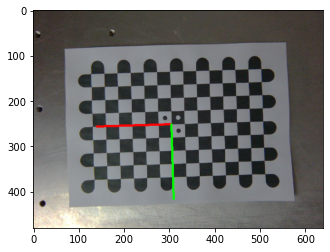

In [5]:
img_name = "radon"
# 载入标定板的RGB彩图
img_rgb = cv2.imread(f"./data/example/radon_caliboard_pose_rgb/{img_name}.png")
# 彩图移除畸变
img_rgb_undistor =camera.remove_distortion(img_rgb)
# 标定板位姿估计
result = caliboard_pose.get_caliboard_pose(img_rgb_undistor)
ret, pose_rgbcam2board,  center,  canvas = result

print("标定板在相机坐标系下的位姿")
print(pose_rgbcam2board)
plt.imshow(canvas[:, :, ::-1])

T_cam2board = pose_rgbcam2board.get_transform_matrix(unit="m")
print(f"T_cam2board:\n {T_cam2board}")

In [6]:
# np.save("T_cam2board.npy", T_cam2board)

In [7]:
# 相机内参
intrinsic = camera.intrinsic_new
# np.save("intrinsic.npy", intrinsic)

In [8]:
# cv2.imwrite(f"./data/example/radon_caliboard_pose_rgb/canvas.png", canvas)

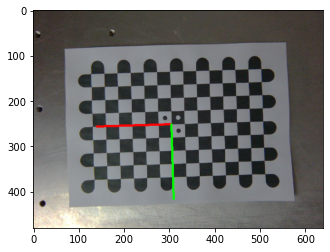

In [9]:
plt.imshow(canvas[:, :, ::-1])

## 绘制相机模型 + 标定板坐标系

In [10]:
# 相机内参
intrinsic = camera.intrinsic_new
T_world2cam = np.eye(4)
# 图像尺寸
img_width = camera.img_width
img_height = camera.img_height
# 可视化相机平面距离相机坐标系原点距离
# 单位m
panel_distance = 0.1

camera_geometries = geometry_camera(intrinsic, T_world2cam, \
        img_width, img_height, \
        panel_distance = panel_distance, \
        color=[0.8, 0.2, 0.2], \
        draw_panel=False)

# 标定板坐标系
coord_board = geometry_coordinate(T_cam2board, size=0.15)

## 绘制标定板模型

In [11]:
# 获取标定板尺寸
# 单位: mm -> m
ceil_size = calibration.config["caliboard"]["ceil_size"]  * 0.001
board_width = calibration.config["caliboard"]["column"] * ceil_size
board_height = calibration.config["caliboard"]["row"] * ceil_size
board_depth = 0.002 # 标定板厚度 # 0.002

print(f"标定板 宽度:{board_width:3f} 高度:{board_height:.3f}  深度:{board_depth}")

标定板 宽度:0.246400 高度:0.158  深度:0.002


In [12]:
board = geometry_box(T_cam2board, board_width, board_height, box_depth=board_depth, color=[0.5, 0.5, 0.5])
# 同时绘制相机模型与标定板坐标系+标定板
draw_geometry(camera_geometries + [coord_board, board], bk_color=[1, 1, 1])